In [15]:
import numpy as np
import matplotlib.pyplot as pp
import pickle, gzip
from tqdm.notebook import tqdm
# Some plotting routines
def binavg(x, n=100, var=False, 
           bounds=False, logx=False):
    if len(x) < n:
        return np.linspace(0, len(x), len(x)), x, 0*x+1, 0 * x, np.stack([x, x]).T
    if logx:
        bins = np.logspace(0, np.log(len(x))/np.log(10), n)
        idx = np.digitize(np.arange(len(x)), bins)
    else:
        bins = np.linspace(0, len(x), n)
        idx = np.int32(np.linspace(0, n, len(x)+1))[:-1]
    counts = np.bincount(idx, minlength=n)
    _y = y = np.bincount(idx, x, minlength=n) / counts
    bins = bins[counts>0]
    y = y[counts>0]
    r = (bins, y, counts)
    if var:
        var = np.sqrt(np.bincount(idx, x**2, minlength=n) / np.bincount(idx, minlength=n) - _y**2)
        r += (var[counts>0], )
    if bounds:
        r += (np.float32([(x[idx==i].min(),x[idx==i].max()) for i in range(n) if counts[i] > 0]), ) 
    return r

def smooth_plot(x, n=100, fill_var=False, fill_minmax=False, logx=False, **kw):
    bins, y, counts, var, bounds = binavg(x, n, var=True, bounds=True, logx=logx)
    if 'bins' in kw:
        bins = kw.pop('bins')[counts>0]
    l, = pp.plot(bins, y, **kw)
    if fill_var:
        pp.fill_between(bins, y-var, y+var, alpha=0.25, color=l.get_c())
    elif fill_minmax:
        pp.fill_between(bins, bounds[:, 0], bounds[:, 1], alpha=0.25, color=l.get_c())
    return l

In [6]:
gen_mols = {}
infos = {}

In [22]:
for i in [15, 16, 63]:
    gen_mols[f'may_{300+i}'] = pickle.load(gzip.open(f'results/array_may_13_{300+i}/sampled_mols.pkl.gz'))
    infos[f'may_{300+i}'] = pickle.load(gzip.open(f'results/array_may_13_{300+i}/info.pkl.gz'))

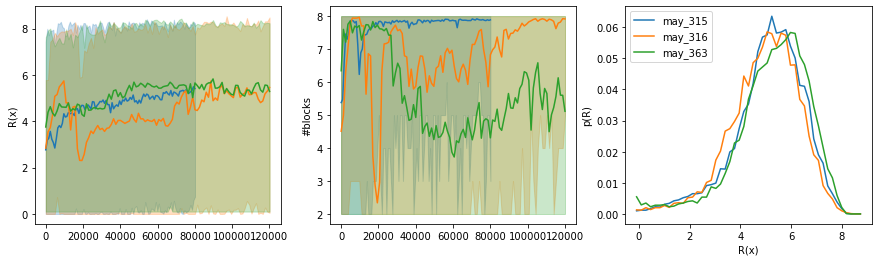

In [25]:
f, ax = pp.subplots(1,3, figsize=(15,4))
bins = np.linspace(1e-8, 9, 50)
midpoint = bins[:-1] + (bins[0] - bins[1])/2
for tag in [f'may_{i}'
     for i in [315, 316, 363]]:
    alpha = infos[tag]['args'].reward_exp if hasattr(infos[tag]['args'], 'reward_exp') else 1
    mols = gen_mols[tag]
    m = infos[tag]['args'].reward_norm if hasattr(infos[tag]['args'], 'reward_norm') else 1
    scores = np.float32([i[0] ** (1/alpha) * m for i in mols])
    pp.sca(ax[0])
    smooth_plot(scores, fill_minmax=True)
    pp.ylabel('R(x)')
    pp.sca(ax[1])
    pp.ylabel('#blocks')
    smooth_plot(np.float32([len(i[1].blockidxs) for i in mols]),
                fill_minmax=True)
    pp.sca(ax[2])
    cnt, _ = np.histogram(scores[-10000:],bins)
    pp.plot(midpoint, cnt / cnt.sum(), label=tag)
    pp.legend()
    pp.xlabel('R(x)')
    pp.ylabel('p(R)')

In [12]:
new_ratios = {}

In [13]:
def comp_ratio_new(mols, minR=0):
    seen = {}
    sr = []
    idxs = []
    u = -1
    for i in tqdm(mols):
        u += 1
        if i[0] < minR: continue
        idxs.append(u)
        blocks = tuple(sorted(list(i[1].blockidxs)))
        if i[0] not in seen:
            seen[i[0]] = {blocks: [i[1]]}
            sr.append(1)
            continue
        a = seen[i[0]]
        if blocks not in a:
            sr.append(1)
            a[blocks] = [i[1]]
            continue
        b = a[blocks]
        ismi = i[1].smiles
        i[1]._smi = ismi
        broke = False
        for j in b:
            if not hasattr(j, '_smi'):
                j._smi = j.smiles
            if j._smi == ismi:
                sr.append(0)
                broke = True
                break
        if not broke:
            sr.append(1)
            b.append(i[1])
    if minR > 0:
        return np.float32(sr), np.int32(idxs)
    return np.float32(sr)

  0%|          | 0/80035 [00:00<?, ?it/s]

  0%|          | 0/120032 [00:00<?, ?it/s]

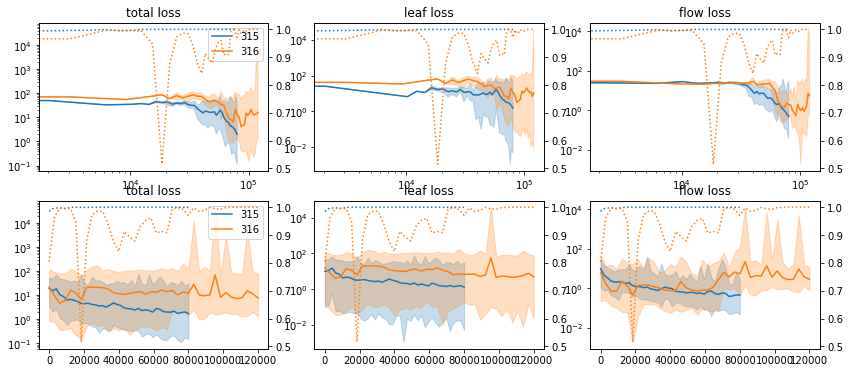

In [16]:
f, ax = pp.subplots(2,3,figsize=(14,6))
twins = {}
for j in range(3):
    for k in range(2):
        pp.sca(ax[k, j])
        for tag, u in [(f'may_{i}', i)
                     for i in [315, 316]
                    ]:
            i = infos[tag]
            l = np.float32(i['train_losses'])
            if len(l) > 1:
                bins = np.linspace(0,len(l)*i['args'].mbsize,40)
                l= smooth_plot(l[:, j], label=str(u), n=40, fill_minmax=True, logx=k == 0,
                           bins=bins)
                if tag not in new_ratios or len(new_ratios[tag]) < len(gen_mols[tag]):
                    new_ratios[tag] = comp_ratio_new(gen_mols[tag])
                if (k,j) not in twins:
                    twins[(k,j)] = pp.twinx()
                pp.sca(twins[(k,j)])
                smooth_plot(new_ratios[tag], n=40, bins=bins, color=l.get_c(), ls=':')
                pp.sca(ax[k,j])
        pp.yscale('log')
        pp.title(['total', 'leaf', 'flow'][j]+' loss')
        if j == 0: pp.legend()
        if k == 0: pp.xscale('log')

In [18]:
all_smiles = {}
top_data = {}
top_mols = {}

In [19]:

slice_size = 100
for k in [10,100,1000]:
    for mi, tag in enumerate(
        ['may_315', 'may_316']
    ):
        alpha = infos[tag]['args'].reward_exp if hasattr(infos[tag]['args'], 'reward_exp') else 1
        mols = gen_mols[tag]
        top_k_line = []
        top_k = [(-10, '', None)]
        top_k_set = set()
        scores = np.float32([i[0] ** (1/alpha) for i in mols])
        for i in (range(0, len(mols), slice_size)):
            m = mols[i:i+slice_size]
            for j in range(slice_size):
                if i+j >= len(mols):break
                m = mols[i+j][1]
                if scores[i+j] > top_k[0][0]:
                    mhash = str(m.blockidxs)+str(m.stems)+str(m.jbonds)
                    if mhash in all_smiles:
                        smi = all_smiles[mhash]
                    else:
                        smi = m.smiles
                        all_smiles[mhash] = smi
                    if smi not in top_k_set:
                        top_k.append((scores[i+j], smi, m))
                        top_k_set.add(smi)
            top_k = sorted(top_k)[-k:]
            top_k_set = set(i[1] for i in top_k)
            top_k_line.append(np.mean([i[0] for i in top_k]))
        top_data[(k, tag)] = top_k_line
        top_mols[(k, tag)] = [i[2] for i in top_k]

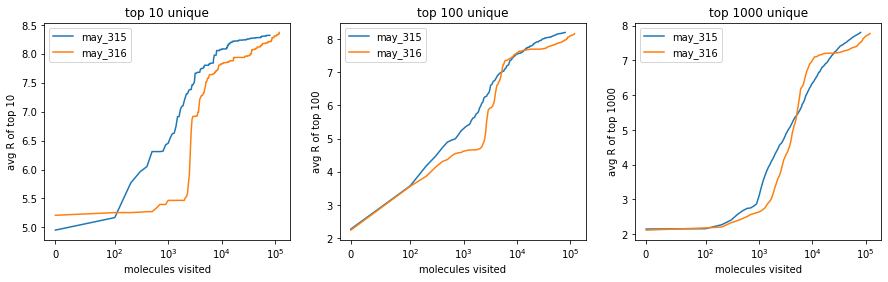

In [20]:
f, ax = pp.subplots(1,3, figsize=(15,4))
for axi, k in enumerate([10,100,1000]):
    pp.sca(ax[axi])
    for mi, tag in enumerate([
        f'may_{i}' for i in [315, 316]]
         #+['ppo_1', 'ppo_7']
         #+['mars_4']
        ): 
        alpha = infos[tag]['args'].reward_exp if hasattr(infos[tag]['args'], 'reward_exp') else 1
        mols = gen_mols[tag]
        m = (infos[tag]['args'].reward_norm if hasattr(infos[tag]['args'], 'reward_norm') else (10 if tag[:3]=='ppo' else 1))
        top_k_line = top_data[(k, tag)]
        if 'ppo' in tag: m=10
        pp.plot(np.arange(len(top_k_line))*slice_size, np.float32(top_k_line) * m, 
                label=tag)
        pp.legend()
        pp.xlabel('molecules visited')
        pp.ylabel(f'avg R of top {k}')
        pp.xscale('symlog', linthresh=1e2)
        pp.title(f'top {k} unique')

9.313226e-20 1.3602502
5.1462697e-12 0.6130971 476
LinregressResult(slope=0.2614407769465926, intercept=-3.0344535277874987, rvalue=0.579471390811624, pvalue=0.0, stderr=0.0052011197825025555)
LinregressResult(slope=0.3549533007718923, intercept=-2.7352908617613996, rvalue=0.4757260567444065, pvalue=2.2982053496094822e-260, stderr=0.009644037683768363)


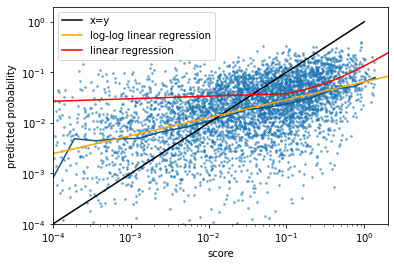

In [23]:
mols = gen_mols['may_363']

import scipy.stats
import matplotlib.cm as cm
f, ax = pp.subplots(1,1)
cidx = 0
probs = np.float32([(np.exp(i[3])) #/ np.exp(i[2][0][2])
        for i in mols[-5000:]])
scores = (np.float32([i[0] for i in mols[-5000:]]))
print(scores.min(), scores.max())
print(probs.min(), probs.max(), probs.argmax())
pp.scatter(scores, probs,  alpha=0.5, s=3)
bins = np.logspace(-4,4,30)
dig = np.digitize(scores, bins)
cat = np.bincount(dig, np.log(probs), minlength=bins.shape[0]) / np.bincount(dig, minlength=bins.shape[0])
pp.plot(bins, np.exp(cat)[:bins.shape[0]], color=np.float32(cm.tab10(cidx))[:3] * 0.7)
cidx += 1
regress = scipy.stats.linregress(np.log(scores), np.log(probs))
print(regress)
regress = scipy.stats.linregress(np.log(scores[scores>1e-4]), np.log(probs[scores>1e-4]))
print(regress)
pp.xscale('log')
pp.yscale('symlog', linthresh = np.exp(4+np.log(probs.min())))
pp.ylabel('predicted probability')
pp.xlabel('score')
pp.xlim(1e-4, 2e0)
pp.ylim(1e-4, 2e0)
#pp.ylim(1e-4, 1e1)
#pp.ylim(probs[scores>1e-4].min(), probs.max())
pp.plot([1e-4, 1], [1e-4, 1], color='black', label='x=y')
x = np.linspace(1e-4, 2e0, 20)
pp.plot(x, np.exp(np.log(x) * regress.slope + regress.intercept),
       color='orange', label='log-log linear regression')
regress = scipy.stats.linregress(scores, probs)
pp.plot(x, x * regress.slope + regress.intercept,
       color='red', label='linear regression')

pp.legend()